#**EDA를 통한 변수 추가 모델**

In [31]:
# 내 드라이브에 대한 주소
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 내 드라이브에 대한 주소
path = "/content/drive/MyDrive/Colab Notebooks/dacon_news"

train = pd.read_csv(path + "/data/news_train.csv")
#try_train = pd.read_csv("try_title_data.csv")
test = pd.read_csv(path + "/data/news_test.csv")

In [4]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


# content 맨앞이 [이거나 (이면 0

In [5]:
train["content_startswith_["]=train.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") or str(x).startswith("제목"))+0

# 타이틀을 이용한 feature
- 해당 title에 몇가지 단어가 들어갈 경우 약 90% 이상이 info가 1

In [6]:
title_noise = ['적중 100%', '글로벌 주요 뉴스', '[전문가 의견]', 
               '[포커스]', '※','■', '▶' ,'◆','★',' TOP', 'BEST',
'전문가의 눈', '전문가선정', '전문가의견','】','후속주도 감사합니다',
               '전문가추천', '주요이슈']

def title_choose(x):
  if ("종목" in x[-6:]) or ("관련주" in x[-5:]):
    return 1
  for noise in title_noise:
    if noise in x.upper():
        return 1
  return 0

In [7]:
train["info1_title"]=train['title'].apply(title_choose)

# content를 이용한 feature

In [8]:
content_noise = ['00%', '긴급공개', '긴급 공개','임상3상', 'TOP','BEST','# ','대장株','대장주','카톡','원"만']

def content_choose(x):
  if (x.count("..")>=2) or (x.count("+")>=2) or (x.count("~")>=2) :
    return 1
  elif (x=='관련기사') or (x=="관련 테마분석") or (x=="코스피") or (x=="코스닥"):
    return 1
  for noise in content_noise:
    if noise in x.upper():
        return 1
  return 0

In [9]:
train["info1_content"]=train["content"].apply(content_choose)

# Order을 이용한 feature

In [10]:
title_group = (train.groupby(["title"]).count())["n_id"]
train["new_ord"]=train.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)

In [11]:
train.head()

,n_id,date,title,content,ord,info,content_startswith_[,info1_title,info1_content,new_ord
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,1,0,0,0.250000
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,0,0,1,0.500000
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,0,0,0,0.750000
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,0,0,0,1.000000
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,0,0,0,0.066667


# tokenization

In [12]:
# konlpy Mecab 사용하기

!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 460kB 42.7MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-

In [13]:
from konlpy.tag import Mecab
import re
from konlpy.tag import Okt

def text_preprocessing(text_list):
    
    stopwords = []
    tokenizer = Mecab() #형태소 분석기

    token_list = [] 
    
    for text in text_list:
        txt = re.sub("[a-zA-Z0-9]", ' ', text) #영문, 숫자 제거 -> 특수문자는 제거하지 않음
        txt = re.sub('[가-힣\s]+기자]','기자', txt) #기자 이름 제거
        token = tokenizer.morphs(txt) #형태소 분석

        token = [t for t in token] 
        token_list.append(token)
        
    return token_list, tokenizer

#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다.
train['new_article'], okt = text_preprocessing(train['content'])

In [14]:
# 결측치 제거
train = train[train["new_article"].apply(lambda x: False if len(x)==0 else True)]

In [15]:
train.head()

,n_id,date,title,content,ord,info,content_startswith_[,info1_title,info1_content,new_ord,new_article
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,1,0,0,0.250000,"[[, 이, 데일리, ], :, 현재, 코스닥, 기관, 억, 순매도]"
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,0,0,1,0.500000,"["", 실적, 기반, "", 저, 가, 에, 매집, 해야, 할, 월, 급등, 유망주,..."
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,0,0,0,0.750000,"[하이스, 탁론, ,, 선취, 수수료, 없, 는, 월, ., %, 최저, 금리, 상..."
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,0,0,0,1.000000,"[종합, 경제, 정보, 미디어, 이, 데일리, -, 무단, 전재, &, 재, 배포,..."
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,0,0,0,0.066667,"[전국, 적, 인, 소비, 붐, 조성, 에, 기여, 할, 예정]"


# Vectorization

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 20

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len, truncating="post") # 길이를 맞춰줌
    return X_train, vocab_size, tokenizer

train_y = train['info']
train_X, vocab_size, vectorizer = text2sequence(train['new_article'], max_len = max_len)

print(train_X.shape, train_y.shape)

# train_X new_article을 vectorizer

vocab_size :  33798
(118676, 20) (118676,)


# Word2Vec

In [17]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [18]:
# 직접 만든 word2vec model
#word2vec_customize = gensim.models.Word2Vec.load("embedding_300_10_10_all.model")

word2vec_customize = gensim.models.Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/dacon_news/embedding/embedding_300_10_30_all.model")
embedding_size = 300

In [ ]:
# """
# 구글 word2vec 모델

# word2vec_g = gensim.models.KeyedVectors.load_word2vec_format(path+'embedding/GoogleNews-vectors-negative300.bin.gz', binary = True)
# embedding_size = 300
# """

In [ ]:
# 한국어 word2vec model
# word2vec2 = gensim.models.Word2Vec.load(path+'/embedding/ko.bin')
# embedding_size = 200


In [19]:
embedding_matrix = np.zeros((vocab_size, embedding_size))
vocab = vectorizer.word_index
count = 0

for idx, word in enumerate(vocab):
    if word in word2vec_customize:
      embedding_vector = word2vec_customize[word]
      embedding_matrix[idx] = embedding_vector
    else: # 임베딩 모델에 없는 것
      #print(word, "word2vec에 없는 단어입니다.")
      count += 1
      pass

print('count: ', count)  

count:  25472


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [20]:
#concat
feature_num = 4
train_X = np.concatenate([train_X,train[["info1_title","info1_content","new_ord","content_startswith_["]].values.reshape(-1,feature_num)], axis=1)
train_X


array([[0.        , 0.        , 0.        , ..., 0.        , 0.25      ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.5       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.75      ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.96153846,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.98076923,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

#train test split

In [ ]:

# 문장별로 train_test set 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, random_state = 42, test_size = 0.3)

In [ ]:
X_train.shape

(83073, 24)

In [ ]:
index_seq = (X_train.argmax(axis=1)).argsort(axis=0)  # 최대값 index를 반환하여 array 정렬
X_train = X_train[index_seq]
y_train = y_train.iloc[index_seq]

In [ ]:
index_seq

array([33419, 74506, 25139, ..., 48543, 48593, 28209])

# stacking 모델링
 GradientBoost,  AdaBoost, CatBoost, ExtraTree

In [22]:
pip install catboost

     |████████████████████████████████| 65.8MB 68kB/s 


In [375]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.externals import joblib
import pickle

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:

# def auc(m, train, test): 
#     return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
#                            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))
    
    
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    

In [ ]:
# 모델 로드

#with open('cb_clf.pkl', 'rb') as f:
#  data = pickle.load(f)

#data

### GradientBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state = 42) # 기본값: max_depth=3, learning_rate=0.1
gb_clf.fit(X_train, y_train)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
gb_pred = gb_clf.predict(X_valid)

gb_acc = accuracy_score(y_valid, gb_pred)
gb_acc

0.9686824144032806

In [ ]:
gbm_params = {
    'n_estimators' : [100, 1000],
    'learning_rate' : [0.01, 0.1],
}


gb_grid = GridSearchCV(gb_clf, param_grid = gbm_params, cv = 3)
gb_grid.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', gb_grid.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(gb_grid.best_score_))

최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 1000}
최고 예측 정확도: 0.945277


In [ ]:
joblib.dump(gb_grid,'gb_clf.pkl')

['gb_clf.pkl']

In [ ]:
gb_pred = gb_grid.best_estimator_.predict(X_valid)

gb_acc = accuracy_score(y_valid, gb_pred)
gb_acc


0.9865741650984468

In [ ]:
gb_pred

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [ ]:
gb_valid_pred = pd.DataFrame(gb_pred, columns =['GradientBoosting'])
gb_valid_pred

,GradientBoosting
0,0
1,0
2,1
3,0
4,1
...,...
35598,0
35599,0
35600,0
35601,1


In [ ]:
# submit

gb_valid_pred.to_csv("gb_valid_pred1.csv", encoding="utf-8-sig",index=False)

### AdaBoost

- n_estimators를 늘린다면

생성하는 weak learner의 수는 늘어남

이 여러 학습기들의 decision boundary가 많아지면서 모델이 복잡해짐

- learning_rate을 줄인다면

가중치 갱신의 변동폭이 감소해서, 여러 학습기들의 decision boundary 차이가 줄어듦

- n_estimoatrs와 learning_Rate는 trade-off 관계
n_estimators(또는 learning_rate)를 늘리고, learning_rate(또는 n_estimators)을 줄인다면 서로 효과가 상쇄됌.

→ 두 파라미터를 잘 조정하는 것이 알고리즘의 핵심.

In [ ]:
DTC = DecisionTreeClassifier(max_depth = 1, random_state=42)

ada_clf = AdaBoostClassifier(base_estimator = DTC, random_state=42) # default: estimators = 50, lr =1
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
ada_pred = ada_clf.predict(X_valid)
ada_acc = accuracy_score(y_valid, ada_pred)
ada_acc


0.9563239052888801

In [ ]:
ada_params = {
    'n_estimators' : [100,1000],
    'learning_rate' : [0.01, 0.1, 1],
}


ada_grid = GridSearchCV(ada_clf, param_grid = ada_params, cv = 3)
ada_grid.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', ada_grid.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(ada_grid.best_score_))

최적 하이퍼 파라미터:
 {'learning_rate': 1, 'n_estimators': 1000}
최고 예측 정확도: 0.926065


In [ ]:
joblib.dump(ada_grid,'ada_grid.pkl')

['ada_grid.pkl']

In [ ]:
# predict
ada_pred = ada_grid.best_estimator_.predict(X_valid)

ada_acc = accuracy_score(y_valid, ada_pred)
ada_acc


0.9763222200376372

In [ ]:
ada_valid_pred = pd.DataFrame(ada_pred, columns =['AdaBoost'])
ada_valid_pred

,AdaBoost
0,0
1,0
2,1
3,0
4,1
...,...
35598,0
35599,0
35600,0
35601,1


In [ ]:
# submit

ada_valid_pred.to_csv("ada_valid_pred1.csv", encoding="utf-8-sig",index=False)

### catBoost

In [ ]:
cb_clf = CatBoostClassifier(random_state=42)
cb_clf.fit(X_train, y_train)

cb_pred = cb_clf.predict(X_valid)


Learning rate set to 0.068005
0:	learn: 0.5920023	total: 105ms	remaining: 1m 44s
1:	learn: 0.5195088	total: 148ms	remaining: 1m 13s
2:	learn: 0.4491934	total: 188ms	remaining: 1m 2s
3:	learn: 0.3974978	total: 233ms	remaining: 58.1s
4:	learn: 0.3606706	total: 274ms	remaining: 54.5s
5:	learn: 0.3327232	total: 315ms	remaining: 52.2s
6:	learn: 0.3065909	total: 357ms	remaining: 50.7s
7:	learn: 0.2837123	total: 406ms	remaining: 50.3s
8:	learn: 0.2685990	total: 451ms	remaining: 49.7s
9:	learn: 0.2563493	total: 493ms	remaining: 48.8s
10:	learn: 0.2455583	total: 531ms	remaining: 47.7s
11:	learn: 0.2322818	total: 572ms	remaining: 47.1s
12:	learn: 0.2246313	total: 618ms	remaining: 46.9s
13:	learn: 0.2162493	total: 659ms	remaining: 46.4s
14:	learn: 0.2088295	total: 712ms	remaining: 46.7s
15:	learn: 0.2018063	total: 757ms	remaining: 46.6s
16:	learn: 0.1959765	total: 798ms	remaining: 46.2s
17:	learn: 0.1897272	total: 846ms	remaining: 46.1s
18:	learn: 0.1840163	total: 886ms	remaining: 45.7s
19:	learn

In [ ]:
joblib.dump(cb_clf,'cb_clf1.pkl')

['cb_clf1.pkl']

In [ ]:
cb_pred

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
cb_acc = accuracy_score(y_valid, cb_pred)
cb_acc


0.9878942785720305

In [ ]:
cb_valid_pred = pd.DataFrame(cb_pred, columns =['catboost'])
cb_valid_pred

,catboost
0,0
1,0
2,1
3,0
4,1
...,...
35598,0
35599,0
35600,0
35601,1


In [ ]:
# submit

cb_valid_pred.to_csv("cb_valid_pred1.csv", encoding="utf-8-sig",index=False)

cb_params = {
    'n_estimators' : [100, 500, 1000],
    'learning_rate' : [0.001, 0.01, 0.1],
}


grid_cv = GridSearchCV(cb_clf, param_grid = cb_params, cv = 3)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(grid_cv.best_score_))

- 최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 100}
  최고 예측 정확도: 0.887512


- valid - acc = 0.9797607318789585

### ExtraTree

- gridCV를 사용했을 때, 오히려 과적합되는 것 같음.(이번 경우에만)

In [ ]:
ext_clf =  ExtraTreesClassifier(random_state=42)
ext_clf.fit(X_train, y_train)

#default n_estimators = 100, max_depth=None

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [ ]:

ext_pred = ext_clf.predict(X_valid)
ext_acc = accuracy_score(y_valid, ext_pred)
ext_acc


0.9769401454933573

In [ ]:
ext_params = {
    'n_estimators' : [100, 1000]
}


ext_cv = GridSearchCV(ext_clf, param_grid = ext_params, cv = 3)
ext_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', ext_cv.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(ext_cv.best_score_))

최적 하이퍼 파라미터:
 {'n_estimators': 1000}
최고 예측 정확도: 0.891168


In [ ]:
ext_cv.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_s

In [ ]:
joblib.dump(ext_cv,'ext_cv1.pkl')

['ext_cv1.pkl']

In [ ]:
# predict
ext_pred = ext_cv.best_estimator_.predict(X_valid)

ext_acc = accuracy_score(y_valid, ext_pred)
ext_acc

0.9771086706176446

In [ ]:
ext_valid_pred = pd.DataFrame(ext_pred, columns =['ExtraTree'])
ext_valid_pred


,ExtraTree
0,0
1,0
2,1
3,0
4,1
...,...
35598,0
35599,0
35600,0
35601,1


In [ ]:
# submit

ext_valid_pred.to_csv("ext_valid_pred1.csv", encoding="utf-8-sig",index=False)

### cv기반 스태킹
- Kfold


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error



# 개별 기반 모델에서 최종 모델이 사용할 train, test 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):

    kf = KFold(n_splits=n_folds, shuffle=False, random_state=42)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        
        model.fit(X_tr , y_tr)       
        
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
       
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:


# gb, ada, cb, ext, lstm 

gb_train, gb_test = get_stacking_base_datasets(gb_clf, X_train, y_train, X_valid, 5)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_valid, 5)
cb_train, cb_test = get_stacking_base_datasets(cb_clf, X_train, y_train, X_valid, 5)
ext_train, ext_test = get_stacking_base_datasets(ext_clf, X_train, y_train, X_valid,  5)    
lstm_train, lstm_test = get_stacking_base_datasets(lstm_clf, X_train, y_train, X_valid,  5)    


NameError: ignored

- StratifiedKFold

### LSTM 모델링

In [ ]:
# EDA기반으로 만든 feature 예측변수로 추가
from keras import regularizers

def LSTM_add_feature(vocab_size, embedding_size = 100, max_len=100):
  input1 = keras.layers.Input(shape = [max_len,]) #문장 단어 input
  input2 = keras.layers.Input(shape = [feature_num,]) # EDA기반 feature input

  # LSTM
  embedding = keras.layers.Embedding(vocab_size, embedding_size, weights = [embedding_matrix], input_length = max_len)(input1) # 임베딩 가중치 적용
  dropout1 = keras.layers.SpatialDropout1D(0.3)(embedding)
  lstm1 = keras.layers.LSTM(32, return_sequences = True)(dropout1)
  lstm2 = keras.layers.LSTM(32)(lstm1)
  dropout2 = keras.layers.Dropout(0.5)(lstm2)
  #lstm_output = keras.layers.Dense(16, activation = "selu")(dropout2)

  # MLP
  concat = keras.layers.concatenate([dropout2,input2])
  hidden = keras.layers.Dense(32, activation = "selu")(concat)
  output = keras.layers.Dense(1, activation = "sigmoid")(hidden)

  model = keras.Model(inputs = [input1, input2], outputs = [output])

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="binary_crossentropy", metrics = "accuracy")
  model.summary()
  return model


In [ ]:
# 훈련 시
tf.random.set_seed(42)


checkpoint_cb = keras.callbacks.ModelCheckpoint("lstm_stacking_valid_model.h5",
                                               save_best_only = True)

# 하이퍼파라미터
max_epoch = 5
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len, embedding_size = embedding_size)
history = model.fit(x=[X_train[:,:max_len],X_train[:,-feature_num:]], y=y_train, epochs=max_epoch,
                batch_size = batch_size,  validation_data = ((X_valid[:,:max_len],X_valid[:,-feature_num:]),y_valid), validation_batch_size = batch_size,
                 callbacks = [checkpoint_cb])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      10139400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 20, 300)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 32)       42624       spatial_dropout1d[0][0]          
______________________________________________________________________________________________

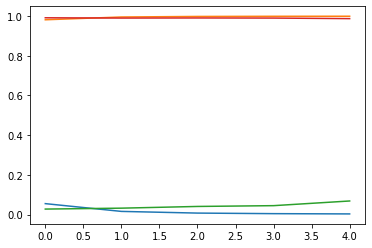

In [ ]:
best_model = keras.models.load_model("lstm_stacking_valid_model.h5") # 저장된 모델 불러오기
plt.plot(pd.DataFrame(history.history)) # 0.0249 0.0211

In [ ]:
# 성능
best_model.evaluate((X_valid[:,:-feature_num],X_valid[:,-feature_num:]),y_valid)

1113/1113 [==============================] - 8s 6ms/step - loss: 0.0277 - accuracy: 0.9912


[0.02765706554055214, 0.9912086129188538]

In [ ]:
lstm_pred = best_model.predict((X_valid[:,:-feature_num],X_valid[:,-feature_num:]))
lstm_pred

array([[5.9819221e-04],
       [1.5429556e-03],
       [9.9947447e-01],
       ...,
       [7.1025491e-03],
       [9.9992704e-01],
       [9.9984050e-01]], dtype=float32)

In [ ]:
lstm_pred1 = lstm_pred.reshape(-1)
lstm_pred1.shape

(35603,)

In [ ]:
lstm_valid_pred = pd.DataFrame(lstm_pred1, columns =['LSTM'])
lstm_valid_pred


,LSTM
0,0.000598
1,0.001543
2,0.999474
3,0.001084
4,0.999927
...,...
35598,0.000387
35599,0.009572
35600,0.007103
35601,0.999927


In [ ]:
# submit

lstm_valid_pred.to_csv("lstm_valid_pred1.csv", encoding="utf-8-sig",index=False)

### 스태킹

- 스태킹할때, gridCV를 사용하면 과적합되는 것 같음.

In [ ]:
# 아래 LSTM_add_feature()로 만든 예측값

lstm_pred1 

array([5.9819221e-04, 1.5429556e-03, 9.9947447e-01, ..., 7.1025491e-03,
       9.9992704e-01, 9.9984050e-01], dtype=float32)

In [ ]:
all_pred = np.array([ada_pred, cb_pred, lstm_pred1])
all_pred.shape

(3, 35603)

In [ ]:
all_pred = np.transpose(all_pred)
all_pred.shape

(35603, 3)

In [ ]:
lgbm_clf=LGBMClassifier(random_state=42)
lgbm_clf.fit(all_pred, y_valid)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:

lgbm_pred = lgbm_clf.predict(all_pred)
lgbm_acc = accuracy_score(y_valid, lgbm_pred)
lgbm_acc


0.9925006319692161

In [ ]:
lgbm_params={'boosting':['gbdt'],
               'objective':['binary'],
               'learning_rate':[0.001,0.05,0.1],
               'max_depth':[2,4,6,8],
               'n_estimators':[100,500,1000]}

grid_lgbm = GridSearchCV(lgbm_clf,param_grid=lgbm_params,cv=3)
grid_lgbm.fit(all_pred,y_valid)


print('최적 하이퍼 파라미터:\n', grid_lgbm.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(grid_lgbm.best_score_))

최적 하이퍼 파라미터:
 {'boosting': 'gbdt', 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'objective': 'binary'}
최고 예측 정확도: 0.992107


In [ ]:
joblib.dump(lgbm_clf,'lgbm_stacking_clf.pkl')

['lgbm_stacking_clf.pkl']

In [ ]:
stacking_pred=grid_lgbm.predict(all_pred)
stacking_pred


array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [ ]:
stacking_acc = accuracy_score(y_valid, stacking_pred)
stacking_acc

0.9922759318034997

In [ ]:
stacking_valid_pred = pd.DataFrame(ext_pred, columns =['gb, cb'])
stacking_valid_pred


,"gb, cb"
0,1
1,0
2,1
3,1
4,1
...,...
35520,1
35521,0
35522,1
35523,1


In [ ]:
# submit

stacking_valid_pred.to_csv("stacking_valid_pred.csv", encoding="utf-8-sig",index=False)

# 전체 train 스태킹 + test

##### test셋 전처리

In [85]:

feature_num = 4
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dacon_news/data/news_test.csv")

# EDA 기반 feature 추가
test["info1_title"]=test["title"].apply(title_choose)
test["info1_content"]=test["content"].apply(content_choose)
test["content_startswith_["]=test.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") or str(x).startswith("제목"))+0
title_group = (test.groupby(["title"]).count())["n_id"]
test["new_ord"]=test.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)
#test["info1_words"]=test["content"].apply(in_bull)

# 전처리
test['new_article'], okt = text_preprocessing(test['content'])
test_X_seq = vectorizer.texts_to_sequences(test["new_article"])
test_X = pad_sequences(test_X_seq, maxlen = max_len, truncating="post") # 길이를 맞춰줌

# concat
test_X = np.concatenate([test_X,test[["info1_title","info1_content","new_ord","content_startswith_["]].values.reshape(-1,feature_num)], axis=1)

In [86]:
test_X.shape

(142565, 24)

##### GBM

In [ ]:
gb_clf = GradientBoostingClassifier(random_state = 42) # 기본값: max_depth=3, learning_rate=0.1

gbm_params = {
    'n_estimators' : [100, 1000],
    'learning_rate' : [0.01, 0.1],
}

gb_grid_tst = GridSearchCV(gb_clf, param_grid = gbm_params, cv = 3)
gb_grid_tst.fit(train_X, train_y)

print('최적 하이퍼 파라미터:\n', gb_grid_tst.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(gb_grid_tst.best_score_))

joblib.dump(gb_grid_tst,'gb_grid_tst.pkl')

gb_pred_tst = gb_grid_tst.best_estimator_.predict(test_X)

gb_test_predict = pd.DataFrame(gb_pred_tst, columns =['GradientBoosting'])
gb_test_predict

최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 1000}
최고 예측 정확도: 0.932118


,GradientBoosting
0,0
1,0
2,0
3,0
4,0
...,...
142560,1
142561,1
142562,1
142563,1


In [ ]:
# submit

gb_test_predict.to_csv("gb_test_predict.csv", encoding="utf-8-sig",index=False)

##### AdaBoost

In [ ]:
DTC = DecisionTreeClassifier(max_depth = 1, random_state=42)
ada_clf = AdaBoostClassifier(base_estimator = DTC, random_state=42) # default: estimators = 50, lr =1

ada_params = {
    'n_estimators' : [100,1000],
    'learning_rate' : [0.01, 0.1, 1],
}

ada_grid_tst = GridSearchCV(ada_clf, param_grid = ada_params, cv = 3)
ada_grid_tst.fit(train_X, train_y)

print('최적 하이퍼 파라미터:\n', ada_grid_tst.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(ada_grid_tst.best_score_))

joblib.dump(ada_grid_tst,'ada_grid_tst.pkl')

# predict
ada_pred_tst = ada_grid_tst.best_estimator_.predict(test_X)

ada_test_pred = pd.DataFrame(ada_pred_tst, columns =['AdaBoost'])
ada_test_pred


최적 하이퍼 파라미터:
 {'learning_rate': 1, 'n_estimators': 1000}
최고 예측 정확도: 0.925487


,AdaBoost
0,0
1,0
2,0
3,0
4,0
...,...
142560,1
142561,1
142562,1
142563,1


In [ ]:

# submit
ada_test_pred.to_csv("ada_test_pred.csv", encoding="utf-8-sig",index=False)

##### catBoost

In [ ]:
cb_clf_tst = CatBoostClassifier(random_state=42)
cb_clf_tst.fit(train_X, train_y)

joblib.dump(cb_clf_tst,'cb_clf_tst.pkl')

cb_pred_tst = cb_clf_tst.predict(test_X)
cb_test_pred = pd.DataFrame(cb_pred_tst, columns =['catboost'])
cb_test_pred


Learning rate set to 0.079193
0:	learn: 0.6147790	total: 103ms	remaining: 1m 42s
1:	learn: 0.5534084	total: 156ms	remaining: 1m 17s
2:	learn: 0.4877203	total: 218ms	remaining: 1m 12s
3:	learn: 0.4497480	total: 271ms	remaining: 1m 7s
4:	learn: 0.4042778	total: 323ms	remaining: 1m 4s
5:	learn: 0.3760851	total: 377ms	remaining: 1m 2s
6:	learn: 0.3465363	total: 440ms	remaining: 1m 2s
7:	learn: 0.3233369	total: 489ms	remaining: 1m
8:	learn: 0.3036278	total: 547ms	remaining: 1m
9:	learn: 0.2910098	total: 599ms	remaining: 59.3s
10:	learn: 0.2760490	total: 666ms	remaining: 59.9s
11:	learn: 0.2668490	total: 720ms	remaining: 59.3s
12:	learn: 0.2574775	total: 772ms	remaining: 58.6s
13:	learn: 0.2503372	total: 826ms	remaining: 58.2s
14:	learn: 0.2437103	total: 883ms	remaining: 58s
15:	learn: 0.2351776	total: 936ms	remaining: 57.5s
16:	learn: 0.2287148	total: 988ms	remaining: 57.1s
17:	learn: 0.2235575	total: 1.04s	remaining: 56.9s
18:	learn: 0.2186865	total: 1.1s	remaining: 56.8s
19:	learn: 0.2135

,catboost
0,1
1,0
2,0
3,0
4,0
...,...
142560,1
142561,1
142562,1
142563,1


In [ ]:
# submit

cb_test_pred.to_csv("cb_test_pred.csv", encoding="utf-8-sig",index=False)

In [ ]:
cb_test_pred.shape

(142565, 1)

##### ExtraTree

In [ ]:
ext_clf =  ExtraTreesClassifier(random_state=42)  #default n_estimators = 100, max_depth=None


ext_params = {
    'n_estimators' : [100, 1000]
}

ext_cv_tst = GridSearchCV(ext_clf, param_grid = ext_params, cv = 3)
ext_cv_tst.fit(train_X, train_y)

print('최적 하이퍼 파라미터:\n', ext_cv_tst.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(ext_cv_tst.best_score_))

joblib.dump(ext_cv_tst,'ext_cv_tst.pkl')


# predict
ext_pred_tst = ext_cv_tst.best_estimator_.predict(test_X)

ext_test_pred = pd.DataFrame(ext_pred_tst, columns =['ExtraTree'])
ext_test_pred


최적 하이퍼 파라미터:
 {'n_estimators': 1000}
최고 예측 정확도: 0.896576


,ExtraTree
0,0
1,0
2,0
3,0
4,0
...,...
142560,1
142561,1
142562,1
142563,1


In [ ]:
# submit

ext_test_pred.to_csv("ext_test_pred.csv", encoding="utf-8-sig",index=False)

##### LSTM

In [ ]:
# 실제 예측시 train
index_seq = (train_X.argmax(axis=1)).argsort(axis=0)
train_X = train_X[index_seq]
train_y = train_y.iloc[index_seq]

tf.random.set_seed(42)

# 하이퍼파라미터
max_epoch = 5
batch_size = 32
learning_rate = 0.001


model = LSTM_add_feature(vocab_size, max_len = max_len, embedding_size = embedding_size)
history = model.fit(x=[train_X[:,:-feature_num],train_X[:,-feature_num:]], y=train_y,epochs=max_epoch,batch_size = batch_size)

model.save("lstm_stacking_test_model.h5")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 20, 300)      10139400    input_11[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 20, 300)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 20, 32)       42624       spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [ ]:
# predict
lstm_tst_model = keras.models.load_model("lstm_stacking_test_model.h5")

lstm_pred_tst = lstm_tst_model.predict([test_X[:,:max_len],test_X[:,-feature_num:]])
lstm_pred_tst1 = lstm_pred_tst.reshape(-1)

lstm_test_pred = pd.DataFrame(lstm_pred_tst1, columns =['LSTM'])
lstm_test_pred

,LSTM
0,5.922311e-01
1,1.026399e-05
2,3.369693e-06
3,3.632282e-07
4,4.333108e-07
...,...
142560,9.999997e-01
142561,1.000000e+00
142562,1.000000e+00
142563,1.000000e+00


In [ ]:
# submit
lstm_test_pred.to_csv("lstm_test_pred.csv", encoding="utf-8-sig",index=False)

##### 스태킹

- train_X로 학습한 모델들 로드.

In [326]:
gb_clf_tr = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 1000, random_state = 42) # 기본값: max_depth=3, learning_rate=0.1
gb_clf_tr.fit(train_X, train_y)

joblib.dump(gb_clf_tr,'gb_clf_tr.pkl')

['gb_clf_tr.pkl']

In [264]:
ext_clf =  ExtraTreesClassifier(random_state=42) 
ext_clf.fit(train_X, train_y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [98]:
joblib.dump(ext_clf,'ext_clf_tr.pkl')

['ext_clf_tr.pkl']

In [376]:
xgb_cl=XGBClassifier(random_state=42)
xgb_params={'objective':['binary:logistic'],'booster':['gbtree'],'n_estimators':[100,500,1000],'learning_rate':[0.001,0.05,0.1],'max_depth':[2,4,8]}
grid_xgb=GridSearchCV(xgb_cl,param_grid=xgb_params,cv=3)
grid_xgb.fit(train_X,train_y)

KeyboardInterrupt: ignored

In [325]:
from sklearn.externals import joblib 

path = "/content/drive/MyDrive/Colab Notebooks/dacon_news/테스트 stacking1"


# gb_grid_tst = joblib.load(path + "/gb_grid_tst.pkl")

# cb_clf_tst = joblib.load(path +  "/cb_clf_tst.pkl")

# ada_grid_tst = joblib.load(path +  "/ada_grid_tst.pkl")


EOFError: ignored

In [36]:
path = "/content/drive/MyDrive/Colab Notebooks/dacon_news/테스트 stacking1"
lstm_tst_model = keras.models.load_model(path + "/lstm_stacking_test_model.h5")


-  train dataset 예측

In [ ]:

pred_xgb=grid_xgb.predict(train_X)

In [328]:
gb_pred_tr = gb_clf_tr.predict(train_X)

In [76]:
ada_pred_tr = ada_grid_tst.predict(train_X)
cb_pred_tr = cb_clf_tst.predict(train_X)
ext_pred_tr = ext_clf.predict(train_X)

In [265]:
ext_pred_tr1 = ext_clf.predict(train_X)

In [78]:
lstm_pred_tr = lstm_tst_model.predict([train_X[:,:max_len],train_X[:,-feature_num:]])
lstm_pred_tr1 = lstm_pred_tr.reshape(-1)

In [161]:
lstm_pred_tr1.shape

(118676,)

In [205]:
rnn_pred_tr = np.array(pd.read_csv('rnn_predicted (1).csv')).reshape(-1)
rnn_pred_tr.shape

(118745,)

In [206]:
a = pd.read_csv('rnn_predicted (1).csv')
a

,0
0,0.000021
1,0.999981
2,0.999972
3,0.000002
4,0.000055
...,...
118740,0.999999
118741,1.000000
118742,1.000000
118743,0.999994


In [329]:
train_all_pred = np.array([ada_pred_tr, cb_pred_tr, ext_pred_tr1, lstm_pred_tr1, gb_pred_tr, pred_xgb])
train_all_pred = np.transpose(train_all_pred)
train_all_pred.shape


(118676, 5)

- test 예측값 로드

In [281]:
ext_pred_tst1 = ext_clf.predict(test_X)
ext_pred_tst1.shape

(142565,)

In [332]:
gb_pred_tst = np.array(pd.read_csv(path+"/gb_test_predict.csv")).reshape(-1)
ada_pred_tst = np.array(pd.read_csv(path+"/ada_test_pred.csv")).reshape(-1)
cb_pred_tst = np.array(pd.read_csv(path+"/cb_test_pred.csv")).reshape(-1)
ext_pred_tst = np.array(pd.read_csv(path+"/ext_test_pred.csv")).reshape(-1)
lstm_pred_tst = np.array(pd.read_csv(path+"/lstm_test_pred.csv")).reshape(-1)

In [327]:
rnn_tst = pd.read_csv('submission (2).csv')
rnn_tst = rnn_tst['info']
rnn_tst.shape

(142565,)

In [333]:
test_all_pred = np.array([ada_pred_tst, cb_pred_tst, ext_pred_tst1, lstm_pred_tst, gb_pred_tst])
test_all_pred = np.transpose(test_all_pred)
test_all_pred.shape


(142565, 5)

In [342]:
train_all_pred.shape

(118676, 5)

In [368]:
test_lgbm_clf=LGBMClassifier(random_state=42)
test_lgbm_clf.fit(train_all_pred, train_y)

# joblib.dump(test_lgbm_clf,'train_lgbm_stacking_clf.pkl')

test_lgbm_pred = test_lgbm_clf.predict(test_all_pred, max_depth=2) #all_pred
test_lgbm_pred


array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [369]:
test_lgbm_clf.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

In [370]:
path = "/content/drive/MyDrive/Colab Notebooks/dacon_news"

submission = pd.read_csv(path+"/data/sample_submission.csv")
submission["info"]=test_lgbm_pred
submission.to_csv("stacking_submission2.csv", encoding="utf-8-sig",index=False)

In [371]:
submission

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [372]:
# sub_fin = pd.read_csv('submission (2).csv')
sub_fin

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [373]:
len(submission[sub_fin['info']!=submission['info']])

4966

In [359]:
len(submission[submission['info']==1])

51787

##### stratified CV

In [207]:

# train
stk_trn = [ada_pred_tr, cb_pred_tr, ext_pred_tr, lstm_pred_tr1]
# test
stk_tst = [ada_pred_tst, cb_pred_tst, ext_pred_tst, lstm_pred_tst]
feature_names = []
model_names = ['ada','cb','ext','lstm']

for model in model_names:
    feature_names += [f'{model}_class0', f'{model}_class1']
    
stk_trn = np.hstack(stk_trn)
stk_tst = np.hstack(stk_tst)

feature_names

['ada_class0',
 'ada_class1',
 'cb_class0',
 'cb_class1',
 'ext_class0',
 'ext_class1',
 'lstm_class0',
 'lstm_class1']

In [220]:
stk_trn = stk_trn.reshape(-1,1)
stk_tst = stk_tst.reshape(-1, 1)

stk_trn.shape

(474704, 1)

In [221]:
y =[train_y, train_y, train_y, train_y]
y = np.hstack(y).reshape(-1, 1)
y.shape

(474704, 1)

In [228]:
a = y.reshape(-1)
a.shape

(474704,)

In [230]:
a

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [232]:
stk_trn

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [217]:
p_val = np.zeros((stk_trn.shape[0], 1))
p_tst = np.zeros((stk_tst.shape[0], 1))
p_val.shape

(474704, 1)

In [250]:
p_val

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [254]:
test_lgbm_pred.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [249]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

p_val = np.zeros((stk_trn.shape[0], 1))
p_tst = np.zeros((stk_tst.shape[0], 1))
for i, (i_trn, i_val) in enumerate(cv.split(stk_trn, y), 1):
    print(f'training model for CV #{i}')
    test_lgbm_clf = LGBMClassifier(random_state=42)
    test_lgbm_clf.fit(stk_trn[i_trn], y[i_trn],eval_set=[(stk_trn[i_val], y[i_val])], verbose=True)
           
    p_val[i_val, :] = (test_lgbm_clf.predict_proba(stk_trn[i_val].reshape)).reshape(-1,1)
    p_tst += test_lgbm_clf.predict_proba(stk_tst) / n_fold
    print(accuracy_score(y[i_val],np.argmax(p_val[i_val],axis=1)))
print()
print('models:',model_names)
print(test_lgbm_clf)

print(f'valid cv accuracy : {accuracy_score(y, np.argmax(p_val, axis=1)) :.6f}')
print(f' {confusion_matrix(y, np.argmax(p_val, axis=1))}')

training model for CV #1
[1]	valid_0's binary_logloss: 0.57889
[2]	valid_0's binary_logloss: 0.504672
[3]	valid_0's binary_logloss: 0.443451
[4]	valid_0's binary_logloss: 0.392087


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	valid_0's binary_logloss: 0.348456
[6]	valid_0's binary_logloss: 0.311045
[7]	valid_0's binary_logloss: 0.278731
[8]	valid_0's binary_logloss: 0.250656
[9]	valid_0's binary_logloss: 0.226149
[10]	valid_0's binary_logloss: 0.204672
[11]	valid_0's binary_logloss: 0.185793
[12]	valid_0's binary_logloss: 0.169153
[13]	valid_0's binary_logloss: 0.154454
[14]	valid_0's binary_logloss: 0.141448
[15]	valid_0's binary_logloss: 0.129923
[16]	valid_0's binary_logloss: 0.119699
[17]	valid_0's binary_logloss: 0.11062
[18]	valid_0's binary_logloss: 0.102554
[19]	valid_0's binary_logloss: 0.0953828
[20]	valid_0's binary_logloss: 0.0890066
[21]	valid_0's binary_logloss: 0.0833364
[22]	valid_0's binary_logloss: 0.0782941
[23]	valid_0's binary_logloss: 0.0738112
[24]	valid_0's binary_logloss: 0.0698268
[25]	valid_0's binary_logloss: 0.0662871
[26]	valid_0's binary_logloss: 0.0631444
[27]	valid_0's binary_logloss: 0.060356
[28]	valid_0's binary_logloss: 0.0578839
[29]	valid_0's binary_logloss: 0.0556

ValueError: ignored

##### 모델 로드

In [40]:
#path = "/content/drive/MyDrive/Colab Notebooks/dacon_news/테스트 stacking1"

#with open("/ada_grid_tst.pkl", 'wb') as f:
#  pickle.dump(ada_grid_tst, f)


NameError: ignored

### cv

In [ ]:

gb_pred_tst = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake news detection/테스트 stacking1/gb_test_predict.csv')
ada_pred_tst= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake news detection/테스트 stacking1/ada_test_pred.csv')
cb_pred_tst= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake news detection/테스트 stacking1/cb_test_pred.csv')
ext_pred_tst = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake news detection/테스트 stacking1/ext_test_pred.csv')
lstm_pred_tst1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake news detection/테스트 stacking1/lstm_test_pred.csv')

gb_pred_tst = np.array(gb_pred_tst).reshape(-1)
ada_pred_tst = np.array(ada_pred_tst).reshape(-1)
cb_pred_tst = np.array(cb_pred_tst).reshape(-1)
ext_pred_tst = np.array(ext_pred_tst).reshape(-1)
lstm_pred_tst1 = np.array(lstm_pred_tst1).reshape(-1)

test_all_pred = np.array([gb_pred_tst, ada_pred_tst, cb_pred_tst, ext_pred_tst, lstm_pred_tst1])
test_all_pred = np.transpose(test_all_pred)
test_all_pred.shape


In [256]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)

        print('ok')
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
tst_x = [X_train[:,:max_len],X_train[:,-feature_num:]]
tst_x

[array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.2000e+01, 1.4530e+03,
         1.4000e+01],
        [1.1690e+03, 1.3300e+02, 1.7510e+03, ..., 9.9710e+03, 1.8000e+01,
         7.7400e+02],
        [1.4800e+03, 6.1900e+02, 4.1000e+01, ..., 3.0500e+02, 8.4300e+03,
         9.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.0000e+01, 7.4100e+02,
         5.0000e+00],
        [6.7400e+02, 1.1195e+04, 5.1840e+03, ..., 2.0000e+00, 7.9200e+02,
         9.0900e+02],
        [2.3200e+02, 1.1740e+03, 3.2920e+03, ..., 2.4000e+01, 1.9430e+03,
         2.5640e+03]]),
 array([[0.        , 0.        , 0.33333333, 1.        ],
        [0.        , 0.        , 0.44444444, 0.        ],
        [0.        , 0.        , 0.7016129 , 0.        ],
        ...,
        [0.        , 0.        , 0.55357143, 0.        ],
        [0.        , 0.        , 0.14705882, 0.        ],
        [0.        , 0.        , 0.15789474, 0.        ]])]

In [260]:

# gb, ada, cb, ext, lstm 

# gb_train, gb_test = get_stacking_base_datasets(gb_grid_tst, train_X, train_y, test_X, 3)
# ada_train, ada_test = get_stacking_base_datasets(ada_grid_tst, train_X, train_y, test_X, 3)
cb_train, cb_test = get_stacking_base_datasets(cb_clf_tst, train_X, train_y, test_X, 3)
# ext_train, ext_test = get_stacking_base_datasets(ext_cv_tst, train_X, train_y, test_X, 3) 
# lstm_train, lstm_test = get_stacking_base_datasets(lstm_tst_model, train_X, train_y, test_X, 3) 


CatBoostClassifier  model 시작 
	 폴드 세트:  0  시작 


KeyError: ignored

In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

NameError: ignored

In [ ]:
stack_final=LGBMClassifier(random_state=42)
stack_final.fit(Stack_final_X_train, y_train)


joblib.dump(stack_final,'stack_final_lgbm_clf.pkl')

stack_predict = stack_final.predict(Stack_final_X_test)
stack_predict

In [ ]:
# submmit

submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dacon_news/data/sample_submission.csv")
submission["info"]= stack_predict

submission.to_csv("stacking1_submission.csv", encoding="utf-8-sig",index=False)

In [ ]:
test_X.shape

(142565, 24)

In [ ]:
train_X.shape

(118676, 24)

In [ ]:
a = np.array([test_X[:,:max_len],test_X[:,-feature_num:]])  #.to_array()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
test_X[:,-feature_num:max_len]

array([], shape=(142565, 0), dtype=float64)

In [ ]:
.shape

(142565, 4)

# 최종 훈련

In [ ]:
# 실제 예측시
index_seq = (train_X.argmax(axis=1)).argsort(axis=0)
train_X = train_X[index_seq]
train_y = train_y.iloc[index_seq]


tf.random.set_seed(40)

# 하이퍼파라미터
max_epoch = 2
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len)
history = model.fit(x=[train_X[:,:-feature_num],train_X[:,-feature_num:]], y=train_y,epochs=max_epoch,batch_size = batch_size)



Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 20, 200)      6692200     input_32[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_12 (SpatialDr (None, 20, 200)      0           embedding_12[0][0]               
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 20, 32)       29824       spatial_dropout1d_12[0][0]       
___________________________________________________________________________________________

In [ ]:
model.save("final_model_99.2.h5")

In [ ]:
final_model = keras.models.load_model("final_model_99.2.h5")

In [ ]:
train_predicted = final_model.predict((train_X[:,:max_len],train_X[:,-feature_num:]))

# 각 문장의 바로 앞문장과, 그 앞 문장의 예측값 생성
train_pre_predicted1 = np.array([train_predicted[idx-1][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞문장
train_pre_predicted2 = np.array([train_predicted[idx-2][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞앞문장
train_pre_predicted3 = np.array([train_predicted[idx-3][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞앞앞문장

In [ ]:
# ord가 1이면 과거 1년도, 2년도 자기값으로 대체
# ord가 2이면 과거 2년도 자기값으로 대체

train["predicted"]=train_predicted
train["pre_predicted1"]=train_pre_predicted1
train["pre_predicted2"]=train_pre_predicted2

train.loc[train["ord"]==1,"pre_predicted1"]=train_predicted[train["ord"]==1]
train.loc[train["ord"]==1,"pre_predicted2"]=train_predicted[train["ord"]==1]
train.loc[train["ord"]==2,"pre_predicted2"]=train_predicted[train["ord"]==2]

In [ ]:
# tree 모델 불러오기
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# xgb model 예측
xgb_model=XGBClassifier(random_state=42)
lgbm_model=LGBMClassifier(random_state=42)

with open(path+'model/new_xgb_model.pkl', 'wb') as f:
  pickle.dump(xgb_model, f)
with open(path+'model/lgbm_model.pkl','wb') as f:
  pickle.dump(lgbm_model,f)

xgb_model.fit(train[["predicted","pre_predicted1","pre_predicted2"]], y=train["info"])
lgbm_model.fit(train[["predicted","pre_predicted1","pre_predicted2"]], y=train["info"])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
def Lag_MLP():
  model = keras.models.Sequential([
    keras.layers.Dense(16, input_shape = (3,)),
    keras.layers.Dense(1)                
  ])
  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="binary_crossentropy", metrics = "accuracy")
  model.summary()
  return model

In [ ]:
# 시퀀셜 LSTM 모델

def Lag_RNN():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(3,1)))
    model.add(keras.layers.SimpleRNN(32))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model.summary()
    return model

In [ ]:
# 하이퍼파라미터
tf.random.set_seed(42)

max_epoch = 5
batch_size = 32
learning_rate = 0.001

lag_model = Lag_RNN()
lag_model.fit(x=train[:82858][["predicted","pre_predicted1","pre_predicted2"]].values.reshape(-1,3,1), y=train[:82858]["info"],
              validation_data = (train[82858:][["predicted","pre_predicted1","pre_predicted2"]].values.reshape(-1,3,1),train[82858:]["info"]), batch_size = 16,
              epochs = max_epoch)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.0471 - accuracy: 0.9914 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 2/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.0140 - accuracy: 0.9968 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 3/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.0112 - accuracy: 0.9977 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 4/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.014

In [ ]:
# 하이퍼파라미터
tf.random.set_seed(42)

max_epoch = 5
batch_size = 32
learning_rate = 0.0001

lag_model = Lag_MLP()
lag_model.fit(x=train[:82858][["predicted","pre_predicted1","pre_predicted2"]], y=train[:82858]["info"],
              validation_data = (train[82858:][["predicted","pre_predicted1","pre_predicted2"]],train[82858:]["info"]), batch_size = batch_size,
              epochs = max_epoch, validation_batch_size = batch_size)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.1080 - accuracy: 0.9517 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 2/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.0168 - accuracy: 0.9961 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 3/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.0132 - accuracy: 0.9968 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 4/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.0212 - accura

# test 예측

In [ ]:
path = "/gdrive/My Drive/dacon_news/"
feature_num = 4
test = pd.read_csv(path+"data/news_test.csv")

# EDA 기반 feature 추가
test["info1_title"]=test["title"].apply(title_choose)
test["info1_content"]=test["content"].apply(content_choose)
test["content_startswith_["]=test.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") or str(x).startswith("제목"))+0
title_group = (test.groupby(["title"]).count())["n_id"]
test["new_ord"]=test.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)
#test["info1_words"]=test["content"].apply(in_bull)

# 전처리
test['new_article'], okt = text_preprocessing(test['content'])
test_X_seq = vectorizer.texts_to_sequences(test["new_article"])
test_X = pad_sequences(test_X_seq, maxlen = max_len) # 길이를 맞춰줌

# concat
test_X = np.concatenate([test_X,test[["info1_title","info1_content","new_ord","content_startswith_["]].values.reshape(-1,feature_num)], axis=1)

In [ ]:
#final_model = keras.models.load_model(path+"model/final_model_99_epoch2.h5") # 저장된 모델 불러오기
final_model = keras.models.load_model("final_model_99.2.h5")
predicted = final_model.predict([test_X[:,:max_len],test_X[:,-feature_num:]])

In [ ]:
d = 

In [ ]:
# idx-1의 예측값
pre_predicted1 = np.array([predicted[idx-1][0] for idx in range(len(predicted))]).reshape(-1,1)
pre_predicted2 = np.array([predicted[idx-2][0] for idx in range(len(predicted))]).reshape(-1,1)

test["predicted"]=predicted
test["pre_predicted1"]=pre_predicted1
test["pre_predicted2"]=pre_predicted2

# ord가 1이면 과거 1년도, 2년도 자기값으로 대체
# ord가 2이면 과거 2년도 자기값으로 대체
test.loc[test["ord"]==1,"pre_predicted1"]=predicted[test["ord"]==1]
test.loc[test["ord"]==1,"pre_predicted2"]=predicted[test["ord"]==1]
test.loc[test["ord"]==2,"pre_predicted2"]=predicted[test["ord"]==2]

In [ ]:
xgb_final_predicted = xgb_model.predict(test[["predicted","pre_predicted1"]])
lgbm_final_predicted = lgbm_model.predict(test[["predicted","pre_predicted1"]])

In [ ]:
xgb_final_predicted = xgb_model.predict(test[["predicted","pre_predicted1","pre_predicted2"]])
lgbm_final_predicted = lgbm_model.predict(test[["predicted","pre_predicted1","pre_predicted2"]])

In [ ]:
wrong = test[(xgb_final_predicted)!=(lgbm_final_predicted)]

In [ ]:
wrong["xgb_predicted"]=xgb_final_predicted[xgb_final_predicted!=lgbm_final_predicted]
wrong["lgbm_predicte"]=lgbm_final_predicted[xgb_final_predicted!=lgbm_final_predicted]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
xgb_train_p = xgb_model.predict(train[["predicted","pre_predicted1","pre_predicted2"]])
lgbm_train_p = lgbm_model.predict(train[["predicted","pre_predicted1","pre_predicted2"]])

In [ ]:
wrong_train = train[(xgb_train_p)!=(lgbm_train_p)]

wrong_train["xgb_predicted"]=xgb_train_p[xgb_train_p!=lgbm_train_p]
wrong_train["lgbm_predicted"]=lgbm_train_p[xgb_train_p!=lgbm_train_p]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
test["info"]=xgb_final_predicted
#test["info"][test["content"].apply(lambda x: True if "무단전재 & 재배포 금지" in x else False)]=0
test["info"][test["content"].apply(lambda x: True if ('http://etoday.bujane.co.kr/' in x) or ('http://bit.ly/2XrAuGJ_itoozanews' in x) or ('http://www.hisl.co.kr/0306/' in x) or ('https://www.hankyung.com/election2020/' in x) or (x==']]') else False)]=1
#test["info"][test["predicted"]>=0.6]=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [ ]:
submission = pd.read_csv(path+"/data/sample_submission.csv")
submission["info"]=test["info"]
submission.to_csv("xgb_drop0.5_submission.csv", encoding="utf-8-sig",index=False)

In [ ]:
submission

,id,info
0,NEWS00237_1,0.0
1,NEWS00237_2,0.0
2,NEWS00237_3,0.0
3,NEWS00237_4,0.0
4,NEWS00237_5,0.0
...,...,...
142560,NEWS09482_72,1.0
142561,NEWS09482_73,1.0
142562,NEWS09482_74,1.0
142563,NEWS09482_75,1.0
